# About: Image Segmentation

Image segmentation clusters pixels into regions of corresponding individual components. This can be done through supervised or unsupervised methods. With supervised methods me manually define segments. With unsupervised methods we let the algorithm work that out. By doing this, we can represent an image as something easier and more meaningful to analyze.

* Supervised image segmentation using seeded region growing. 
* Image segmentation using Felzenszwalb and fast scanning algorithms. 
* Small segment pruning

# Notes:
* With imshow() we can create a window where we can obtain pixel values by moving the cursor around the image.

# Libraries

In [1]:
using Pkg, Images, ImageSegmentation, ImageView

Gtk-Message: 13:45:41.112: Failed to load module "canberra-gtk-module"
Gtk-Message: 13:45:41.113: Failed to load module "canberra-gtk-module"


# User-Defined Functions

In [2]:
function mosaic_output_1d(img_left, img_right, mosaic)
    """    
    Input:
    * img_left: Original image
    * img_right: New and processed image
    * mosaic: Boolean parameter defining if this function will return either a mosaic of two images side by side or a single image
    
    """
    if mosaic
        return mosaicview(img_left, img_right; nrow = 1)
    else 
        return img_right
    end
end;

In [3]:
function sharpened_image(img, gaussian_smoothing, intensity, mosaic = true)
    """
    Input:
    * gaussian_smoothing ∈ [1, 4] (reccommended)
    * intensity ∈ [0.5, 1] (reccommended)
    """
    
    blurred_img = imfilter(img, Kernel.gaussian(gaussian_smoothing));
    
    # To perform mathematical operations, we convert to Float.
    img_array = Float16.(channelview(img));
    blurred_img_array = Float16.(channelview(blurred_img));
    
    # Sharpen image. Fix values from 0 to 1
    sharpened_img = img_array.*(1+intensity) .+blurred_img_array .*(-intensity)
    sharpened_img = max.(sharpened_img, 0)
    sharpened_img = min.(sharpened_img, 1)
    sharpened_img = colorview(RGB, sharpened_img)
    
    return mosaic_output_1d(img, sharpened_img, mosaic)
    
end; 

# Main

## > Supervised Methods

### - Supervised: Seeded region growing
This function helps to separate one (1) *simple* foreground object from the rest of the background by using the information from a seed pixel value. This is a manual method, so, we need so supply the coordinates for each relevant area.

It is helpful when preparing samples for training datasets.

* A *simple* image has a foreground object that contrasts sharply against the background.
* A *complex* image has a foreground object that has colors that are similar to the background, making it be composed of multiple color segments

In [4]:
function seed_grow_image(img, seeds, mosaic = true)
    segments = seeded_region_growing(img, seeds)

    sg_img = map(i->segment_mean(segments,i), labels_map(segments))
    
    return mosaic_output_1d(img, sg_img, mosaic)
end;

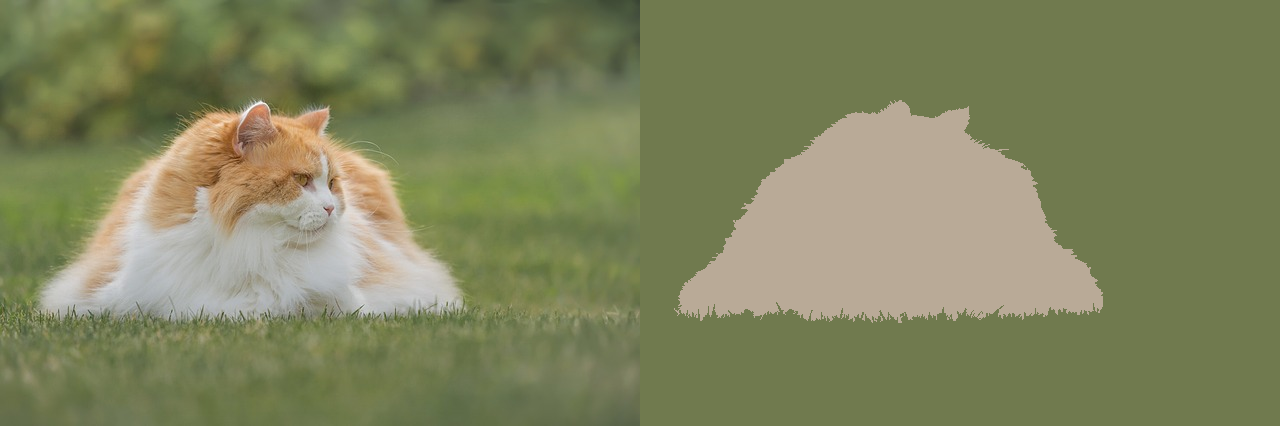

In [5]:
# ----------------------------
# Simple image test
# ----------------------------

# Inputs:
img = load("Images/cat-3352842_640.jpg");
# Segments are defined as arrays of tuples using CartesianIndex. We choose pixels as seeds.
seeds = [(CartesianIndex(308, 318),1), 
         (CartesianIndex(220, 500),2)]

# Seed Growing function
sg_img = seed_grow_image(img, seeds)

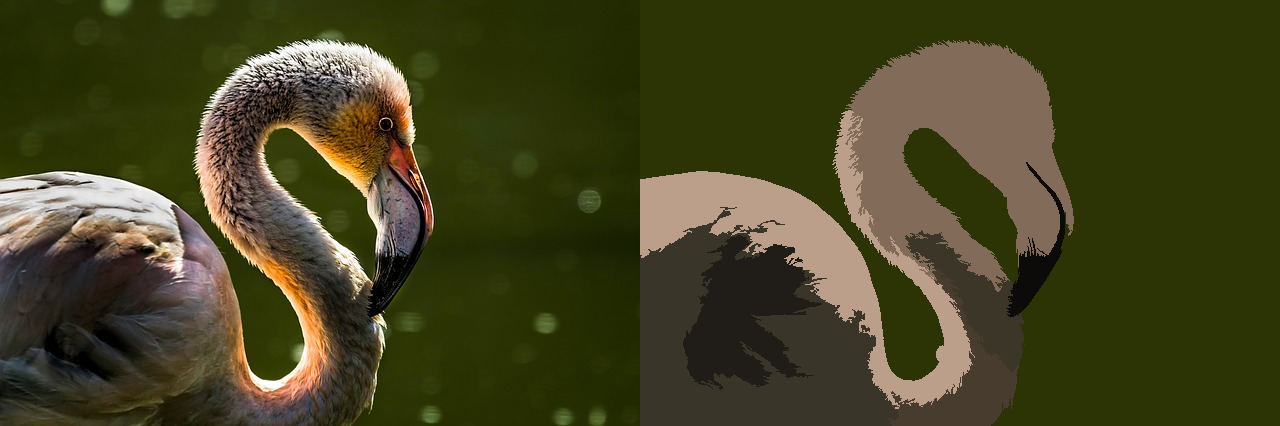

In [6]:
# ----------------------------
# Complex image test
# ----------------------------
img = load("Images/bird-3183441_640.jpg");
#imshow(img)
seeds = [
    (CartesianIndex(240,120), 1),
    (CartesianIndex(295,70), 2),
    (CartesianIndex(319,40), 3),
    (CartesianIndex(90,300), 4),
    (CartesianIndex(295,325), 5),
    # We can repeat region indexes to refer as same kind of object
    (CartesianIndex(76,135), 6),
    (CartesianIndex(200,320), 6),
    (CartesianIndex(290,390), 7),
    (CartesianIndex(420,350), 8)
]

# Seed Growing function
sg_img = seed_grow_image(img, seeds)

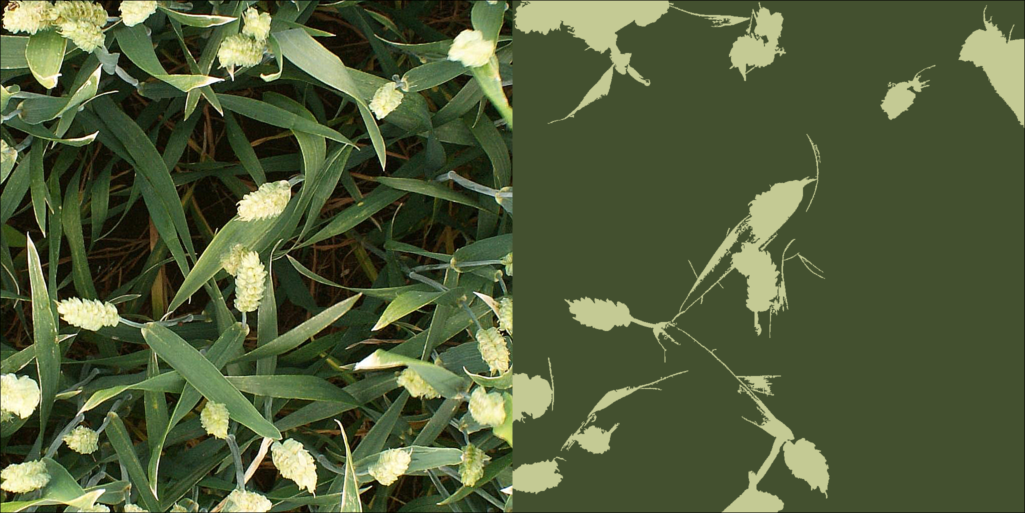

In [7]:
# Wheat test

# Inputs
img = load("kaggle-test/2fd875eaa.jpg")
img = sharpened_image(img, 1, 4, false)

seeds = [(CartesianIndex(630, 175),2), 
         (CartesianIndex(670, 215),1),
         (CartesianIndex(25, 67),2),
    (CartesianIndex(100, 500),2),
    (CartesianIndex(200, 780),2),
    (CartesianIndex(100, 920),2),
    (CartesianIndex(400, 530),2),
    (CartesianIndex(570, 510),2),
    (CartesianIndex(790, 40),2),
    (CartesianIndex(25, 67),2),
    (CartesianIndex(870, 165),2),
    (CartesianIndex(970, 50),2),
    (CartesianIndex(840, 530),2)        
]

seed_grow_image(img, seeds)

## > Unsupervised Methods
Unsupervised methods don't require a manual input to create regions. This process is automatic with the help of some hyper-parameters.

### - Graph-based approach: Felzenszwalb
Benefits:
* Requires few hyper-parameters
* Fast and linear execution time
* Preserves details in areas of low variability.

Parameter values will change depending on the task:
* threshold [10-500]: Used for region merging step (bigger value, bigger segment).
* Minimum Segment size [>20] (Optional).

In [8]:
function felzenszwalb_image(img, threshold, min_segment_size = 1)    
    # Creating segments with information about each pixel and class.
    f_img = felzenszwalb(img, threshold, min_segment_size)
    
    # convert image segments to mean color value
    out_img = map(i->segment_mean(f_img, i), labels_map(f_img))
        
    return out_img
end;

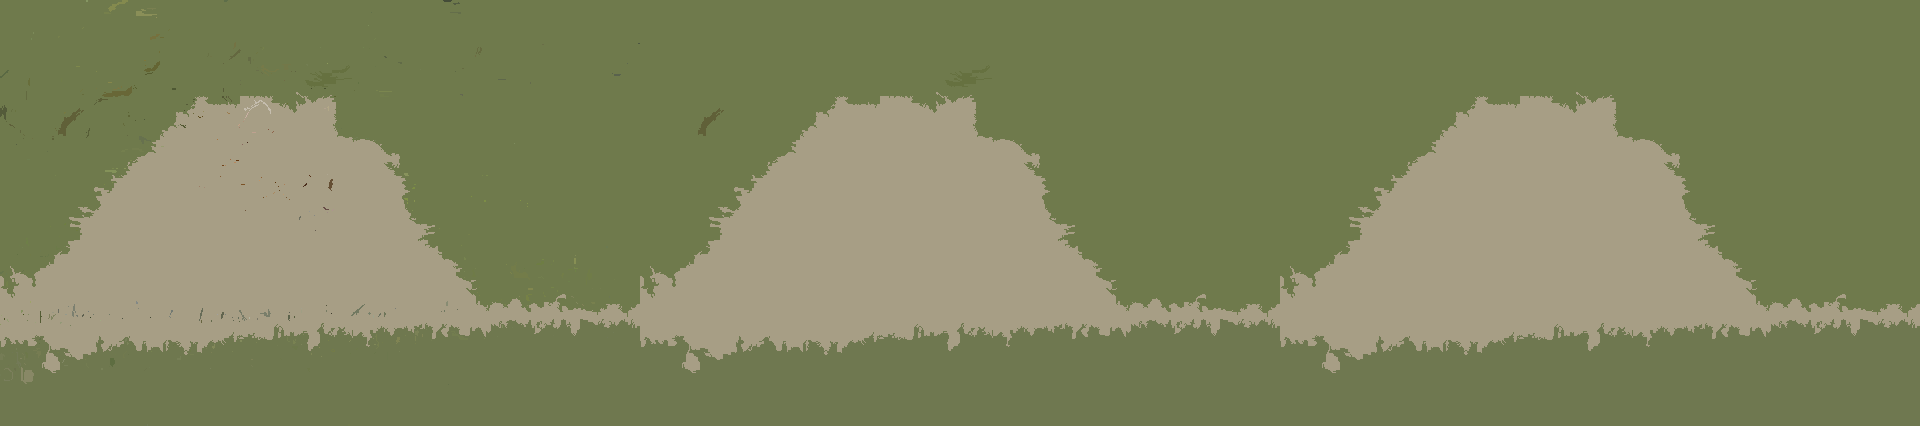

In [9]:
img = load("Images/cat-3352842_640.jpg");
mosaicview(felzenszwalb_image(img, 75), felzenszwalb_image(img, 75, 150), felzenszwalb_image(img, 75, 350), nrow = 1)

# By increasing the segment size, we reduced each time more the number of background and foreground details. 

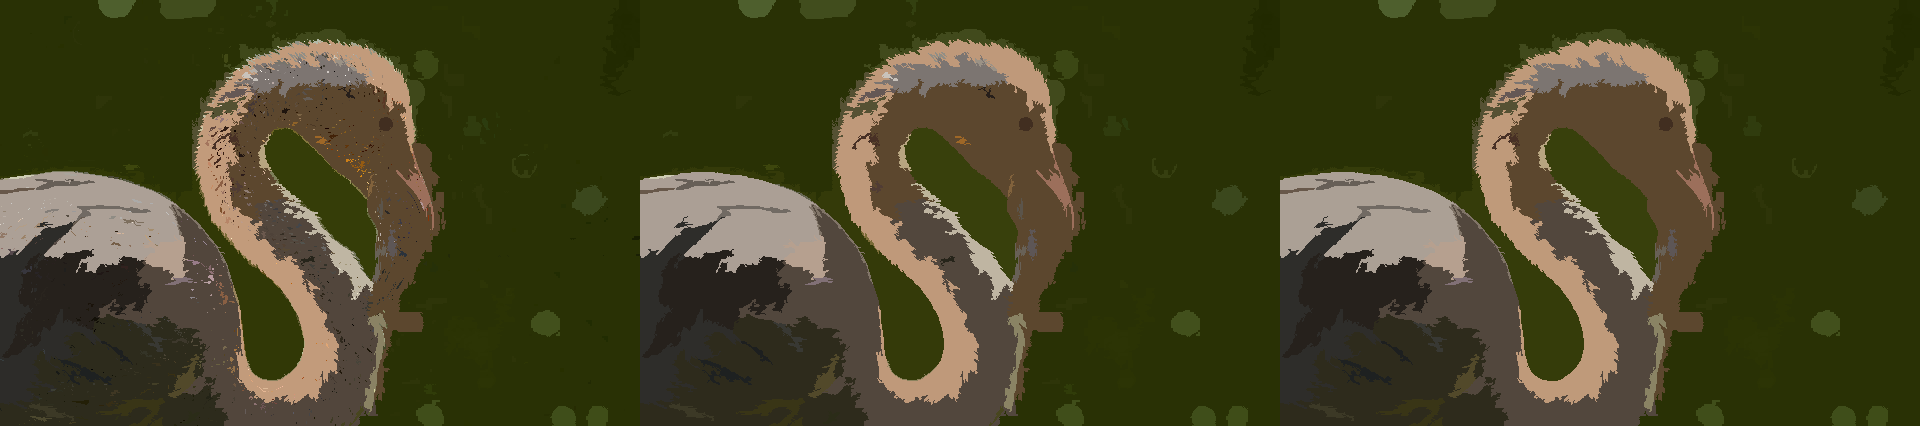

In [10]:
img = load("Images/bird-3183441_640.jpg");
mosaicview(felzenszwalb_image(img, 10)
    , felzenszwalb_image(img, 10, 50)
    , felzenszwalb_image(img, 10, 100), nrow = 1)

# By increasing the segment size, we reduced each time more the number of background and foreground details. 

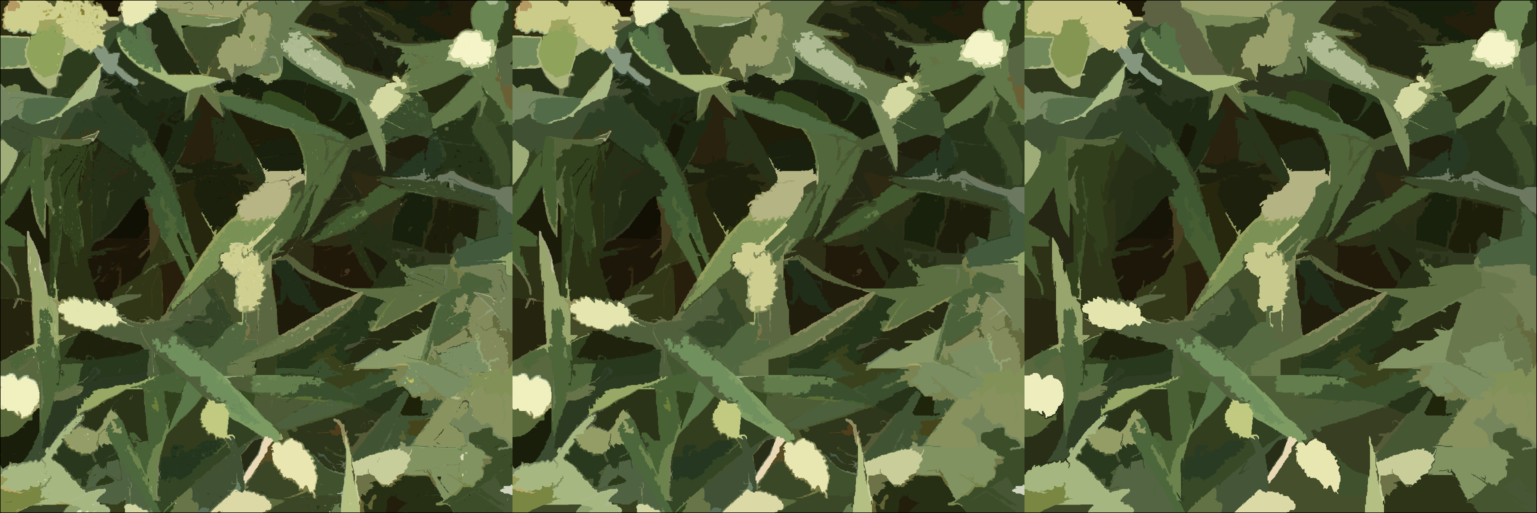

In [11]:
# Wheat test
img = load("kaggle-test/2fd875eaa.jpg")
mosaicview(felzenszwalb_image(img, 5)
    , felzenszwalb_image(img, 5, 100)
    , felzenszwalb_image(img, 5, 1000), nrow = 1)

### - Fast-scanning approach
The `fast_scanning()` algorithm works by scanning and grouping neighboring similar pixels within a threshold.

Parameters:
* Image: Color or grayscale
* Threshold: Float value or matrix in size of the image.
* diff_fn: Custom function to calculate the difference

In [45]:
function fast_scan_image(img, fs_threshold, min_segment = 0)    
    fs_img = fast_scanning(img, fs_threshold)

    segment_to_image(segments) = map(i->segment_mean(segments, i), labels_map(segments))
    new_img = segment_to_image(fs_img)

    # prune segments
    if min_segment > 0
        deletion_rule = i -> (segment_pixel_count(fs_img,i) < min_segment)
        replacement_rule = (i,j) -> (-segment_pixel_count(fs_img, j))
        segments_n = prune_segments(fs_img, deletion_rule, replacement_rule)
        out_img = segment_to_image(segments_n)
    else
        out_img = new_img
    end

end;

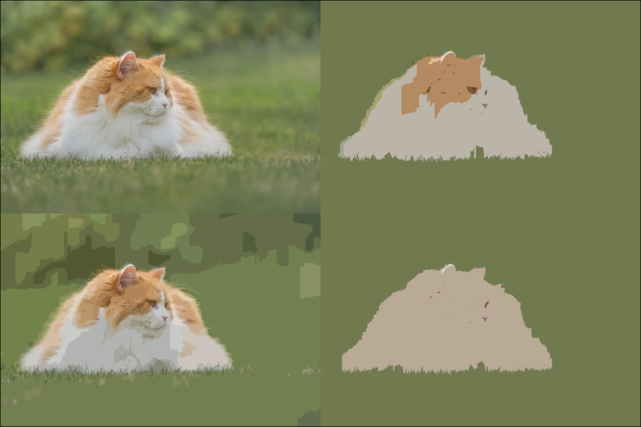

In [76]:
img = load("Images/cat-3352842_640.jpg");
mosaicview(img, fast_scan_image(img, 0.05), fast_scan_image(img, 0.15), fast_scan_image(img, 0.20), nrow=2, ncol=2)

# In the third image, the algorithm kept some small details. 
# We need to use a pruning technique 

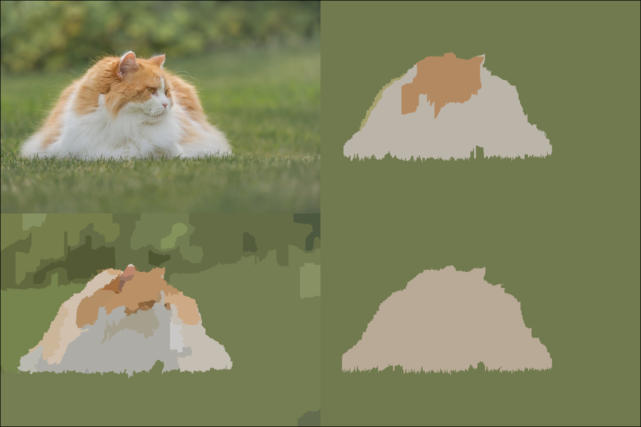

In [78]:
min_segment = 750
mosaicview(img, fast_scan_image(img, 0.05, min_segment), fast_scan_image(img, 0.15, min_segment), fast_scan_image(img, 0.20, min_segment), nrow=2, ncol=2)

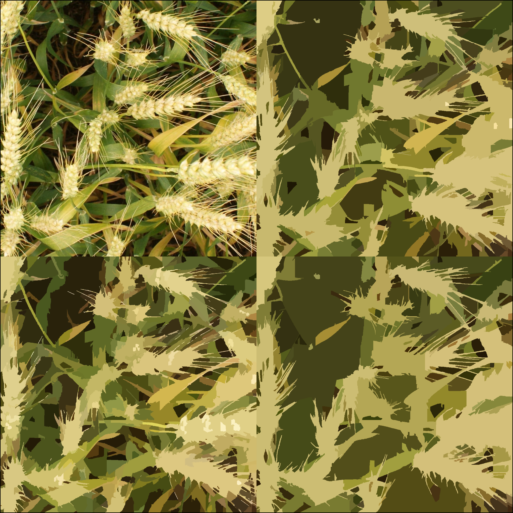

In [74]:
# Wheat test
img = load("kaggle-test/51b3e36ab.jpg")
min_segment = 250
mosaicview(img, fast_scan_image(img, 0.10, min_segment)
          , fast_scan_image(img, 0.15, min_segment), fast_scan_image(img, 0.20, min_segment)
          , nrow=2, ncol=2)